## Summary

----

## Imports

In [1]:
import json
import os
import os.path as op
import shlex
import shutil
import subprocess
import sys
import tempfile
import time
import xml.etree.ElementTree as ET
from pathlib import Path
from textwrap import dedent

import numpy as np
from IPython.display import HTML, SVG, display
from tqdm.notebook import tqdm

import kmtools.sci_tools
import matplotlib.pyplot as plt
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch_geometric
from kmbio import PDB
from matplotlib.ticker import FuncFormatter
from torch_geometric.data import Batch

/home/strokach/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:27: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning,


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed for pdf2svg
PYTHON_PATH = op.dirname(sys.executable)

if PYTHON_PATH not in os.environ["PATH"]:
    os.environ["PATH"] = f'{PYTHON_PATH}:{os.environ["PATH"]}'

## Properties

In [4]:
NOTEBOOK_NAME = "11_analyze_generated_sequences"

In [5]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/11_analyze_generated_sequences')

In [6]:
UNIQUE_ID = "191f05de"

In [7]:
DESIGNS_PATH = NOTEBOOK_PATH.parent.joinpath("generate_protein_sequences")
assert DESIGNS_PATH.is_dir()

DESIGNS_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences')

In [8]:
SEQUENCE_GENERATION_METHOD = "expectimax"

assert SEQUENCE_GENERATION_METHOD in ("astar", "randexpectimax", "expectimax", "logexpectimax", "root2expectimax", "root10expectimax")

In [9]:
# STRUCTURE_ID = "1n5uA03"  # poster
# STRUCTURE_ID = "4z8jA00"
STRUCTURE_ID = "4unuA00"
# STRUCTURE_ID = "4beuA02"  # poster

STRUCTURE_ID

'4unuA00'

In [14]:
STRUCTURE_FILE = NOTEBOOK_PATH.parent.parent.joinpath("data", "inputs", f"{STRUCTURE_ID}.pdb")
assert STRUCTURE_FILE.is_file()

STRUCTURE_FILE

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/data/inputs/4unuA00.pdb')

In [15]:
with DESIGNS_PATH.joinpath(f"stats-{UNIQUE_ID}-{STRUCTURE_FILE.stem}.json").open("rt") as fin:
    model_stats = json.load(fin)

model_stats

{'map_sequence_identity': 0.43119266055045874,
 'map_proba': 0.46164458990097046,
 'map_logproba': -0.8745880126953125,
 'ref_sequence_identity': 1.0,
 'ref_proba': 0.3054293692111969,
 'ref_logproba': -1.7174205780029297}

## Load structure

In [16]:
structure_all = PDB.load(STRUCTURE_FILE)
structure = PDB.Structure(STRUCTURE_FILE.name + "A", structure_all[0].extract('A'))
assert len(list(structure.chains)) == 1

In [17]:
view = PDB.view_structure(structure)

view

NGLWidget()

## Design pipeline

### Load protein sequence and geometry

In [18]:
structure = PDB.load(STRUCTURE_FILE)
pdata = proteinsolver.utils.extract_seq_and_adj(structure, 'A')
print(pdata)

ProteinData(sequence='SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL', row_index=array([  0,   0,   0, ..., 106, 106, 107]), col_index=array([  1,   2,   3, ..., 107, 108, 108]), distances=array([1.29767875, 3.76060342, 6.58874989, ..., 1.32708647, 4.12791238,
       1.32601478]))


In [19]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
print(data.edge_attr.min())
data = proteinsolver.datasets.protein.transform_edge_attr(data)
print(data.edge_attr.min())

tensor(1.2700)
tensor(-1.4971)


In [20]:
sequence_ref = pdata.sequence
print(len(sequence_ref), sequence_ref)

109 SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL


### Convert designs into a DataFrame

In [21]:
design_files = list(DESIGNS_PATH.glob(f"designs-{UNIQUE_ID}-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}-*.parquet"))
design_files[-5:]

[PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4unuA00-2039-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4unuA00-7068-c01.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4unuA00-1048-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4unuA00-8089-c01.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-4unuA00-6074-c01.parquet')]

In [22]:
dfs = []
for design_file in tqdm(design_files):
    df = pq.read_table(design_file).to_pandas(integer_object_nulls=True)
    dfs.append(df)
df = pd.concat(dfs, sort=False)

In [23]:
print(len(df))
df = df.drop_duplicates(subset=["sequence"])
print(len(df))

6460045
6460045


In [ ]:
df["seq_identity"] = [
    sum(sequence_ref[i] == sequence[i] for i in range(len(sequence_ref))) / len(sequence_ref)
    for sequence in df["sequence"]
]

In [ ]:
df.head(2)

### Save result to single dataframe

In [23]:
pq.write_table(
    pa.Table.from_pandas(df, preserve_index=False),
    NOTEBOOK_PATH.joinpath(f"data-combined-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}.parquet"),
    row_group_size=100_000,
)

## Make plots

### Sequence identity

In [24]:
model_stats

{'map_sequence_identity': 0.4166666666666667,
 'map_proba': 0.48954343795776367,
 'map_logproba': -0.7965440154075623,
 'ref_sequence_identity': 1.0,
 'ref_proba': 0.325325071811676,
 'ref_logproba': -1.840335726737976}

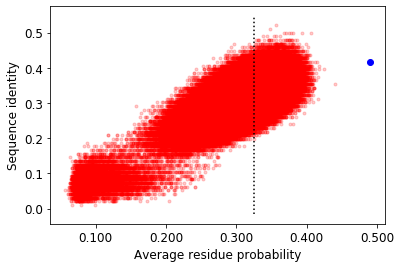

In [25]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    ax.plot(df["probas_sum"] / len(sequence_ref), df["seq_identity"], "r.", alpha=0.2)
    ax.plot(model_stats["map_proba"], model_stats["map_sequence_identity"], "bo")
    ax.vlines(model_stats["ref_proba"], *ax.get_ylim(), linestyles=":", zorder=10)
    ax.set_xlabel("Average residue probability")
    ax.set_ylabel("Sequence identity")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3f}"))

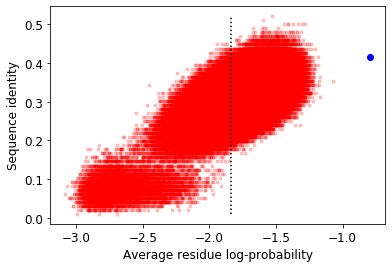

In [26]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots()
    ax.plot(df["probas_log_sum"] / len(sequence_ref), df["seq_identity"], "r.", alpha=0.2)
    ax.plot(model_stats["map_logproba"], model_stats["map_sequence_identity"], "bo")
    ax.vlines(
        model_stats["ref_logproba"], df["seq_identity"].min(), df["seq_identity"].max(), linestyles=":", zorder=10
    )
    ax.set_xlabel("Average residue log-probability")
    ax.set_ylabel("Sequence identity")

### Adjacency matrix

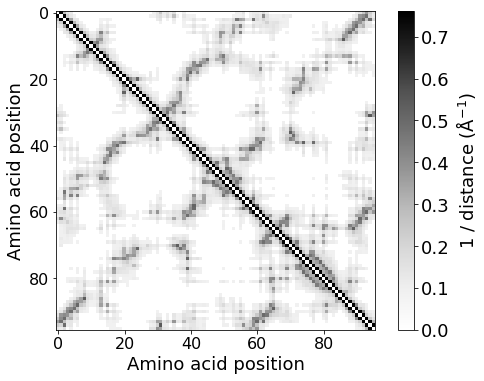

In [27]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
adj = torch_geometric.utils.to_dense_adj(edge_index=data.edge_index, edge_attr=1 / data.edge_attr[:, 0]).squeeze()

with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    out = ax.imshow(adj, cmap="Greys")
    ax.set_ylabel("Amino acid position")
    ax.set_xlabel("Amino acid position")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("1 / distance (Å$^{-1}$)")

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-adjacency.svg"), bbox_inches="tight")

### Score distributions

In [28]:
df.head(2)

,sequence,probas_sum,probas_log_sum,seq_identity
0,MPRTVVFEQDKHGFGFKVEGYTMNAGQKLALNGVEFEPVLRIKECL...,32.219791,-155.711105,0.343750
1,GPRKIELKRDDHGTGFTVTAYSDEGDEEVRINGRSFKPVLSVTGVE...,28.419151,-172.234055,0.302083


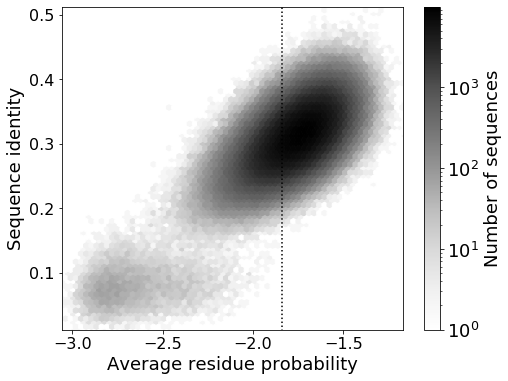

In [29]:
with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    x = df["probas_log_sum"] / len(sequence_ref)
    #     x = np.exp(df["probas_log_sum"] / df["sequence"].str.len())

    #     y = df["seq_identity"].values
    y = df["seq_identity"].values + 0.005 * np.random.randn(len(df))

    nbins = 20
    xlim = np.quantile(x, 0.000001), np.quantile(x, 0.999999)
    ylim = np.quantile(y, 0.000001), np.quantile(y, 0.9999999)

    #     k = kde.gaussian_kde(np.vstack([x, y]))
    #     xi, yi = np.mgrid[xlim[0] : xlim[1] : nbins * 1j, ylim[0] : ylim[1] : nbins * 1j]
    #     zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    #     out = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="Greys")

    #     ax.plot(model_stats["map_proba"], model_stats["map_sequence_identity"], "ro", fillstyle="none")

    out = ax.hexbin(x, y, gridsize=70, bins="log", cmap="Greys")

    ax.vlines(model_stats["ref_logproba"], y.min(), y.max(), linestyles=":", zorder=10)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Sequence identity")
    ax.set_xlabel("Average residue probability")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("Number of sequences")

fg.tight_layout()
fg.savefig(
    NOTEBOOK_PATH.joinpath(f"hexbin-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}.svg"), bbox_inches="tight"
)

### Sequence logo

In [30]:
stacks_per_line = 110

In [31]:
for i in range(0, len(sequence_ref), stacks_per_line):
    svg_file_wt = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-wt-{i}.svg")

    kmtools.sci_tools.make_weblogo(
        [sequence_ref[i : i + stacks_per_line]],
        units="bits",
        color_scheme="hydrophobicity",
        stacks_per_line=stacks_per_line,
        format_="svg",
        aspect_ratio=1,
        show_xaxis=False,
        show_yaxis=False,
        errorbars=False,
        ylabel="",
        output_file=svg_file_wt,
    )

In [32]:
xxx = df[(df["probas_sum"] > 0.15 * len(sequence_ref)) & (df["seq_identity"] < 0.15)]

for i in range(0, len(sequence_ref), stacks_per_line):
    svg_file_gen = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-gen-{i}.svg")

    kmtools.sci_tools.make_weblogo(
        df["sequence"].str[i : i + stacks_per_line].values,
        units="bits",
        color_scheme="hydrophobicity",
        stacks_per_line=stacks_per_line,
        format_="svg",
        aspect_ratio=5,
        #     show_xaxis=False,
        #     show_yaxis=False,
        errorbars=False,
        #     ylabel="",
        output_file=svg_file_gen,
        annotate=",".join(
            (str(n + 1) if (n + 1) % 5 == 0 else "") for n in range(i, min(len(sequence_ref), i + stacks_per_line))
        ),
        number_interval=5,
    )

In [33]:
def process_svg(file_in, file_out):
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    tree = ET.parse(file_in)
    root = tree.getroot()

    width = root.attrib.pop("width", "").strip("pt")
    height = root.attrib.pop("height", "").strip("pt")
    _, _, width_vb, height_vb = root.attrib["viewBox"].split(" ")
    assert not width or width == width_vb, (width, width_vb)
    assert not height or height == height_vb, (height, height_vb)

    root.attrib["preserveAspectRatio"] = "none"
    tree.write(file_out)

    return width_vb, height_vb

In [34]:
def generate_inner_div(svg_file_wt, svg_file_gen, scale=1, relative_to=Path.cwd()):
    html_doc = f"""\
        <div>
        <img src="{svg_file_wt.relative_to(relative_to)}" style="display: block; margin-left: auto; margin-bottom: -0.9%; width: {scale:%}" />
        <img src="{svg_file_gen.relative_to(relative_to)}" style="display: block; width: 100%" />
        </div>
        """
    return html_doc

In [52]:
def combine_wt_and_gen(svg_file_wt, svg_file_gen, output_file_stem):
    with tempfile.TemporaryDirectory() as temp_dir:
        width_wt, height_wt = process_svg(svg_file_wt, Path(temp_dir, svg_file_wt.name))
        width_gen, height_gen = process_svg(svg_file_gen, Path(temp_dir, svg_file_gen.name))

        inner_div = generate_inner_div(
            Path(temp_dir, svg_file_wt.name),
            Path(temp_dir, svg_file_gen.name),
            scale=float(width_wt) / float(width_gen),
            relative_to=temp_dir,
        )

        html_doc = dedent(
            f"""\
            <!DOCTYPE html>
            <html>

            <head>
              <meta charset="utf-8">
              <title></title>
              <meta name="author" content="">
              <meta name="description" content="">
              <meta name="viewport" content="width=device-width, initial-scale=1">
                <style>
                @media print {{
                    @page {{ size: {width_gen}px {int(height_gen) + 14}px; margin: 0; }}
                    html, body {{ margin: 0; }}
                }}
                </style>
            </head>

            <body>

            {inner_div}

            </body>

            </html>
            """
        )

        html_file = Path(temp_dir, "output.html")
        with html_file.open("wt") as fout:
            fout.write(html_doc)

        pdf_file = Path(temp_dir, "output.pdf")
        system_command = f'{Path("~/opt/chrome-linux/chrome").expanduser()} --headless --disable-gpu --print-to-pdf "{html_file}"'
        cp = subprocess.run(shlex.split(system_command), cwd=temp_dir, check=True)

        svg_file = pdf_file.with_suffix(".svg")
        system_command = f'pdf2svg "{pdf_file}" "{svg_file}"'
        cp = subprocess.run(shlex.split(system_command), cwd=temp_dir, check=True)
        assert svg_file.is_file()

        shutil.copy2(pdf_file, output_file_stem.with_suffix(".pdf"))
        shutil.copy2(svg_file, output_file_stem.with_suffix(".svg"))

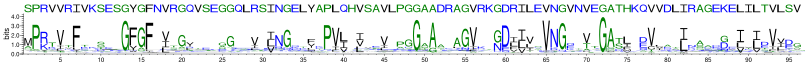

In [53]:
for i in range(0, len(sequence_ref), stacks_per_line):
    svg_file_wt = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-wt-{i}.svg")
    svg_file_gen = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-gen-{i}.svg")
    svg_file = NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + f"-weblogo-{i}.svg")

    combine_wt_and_gen(svg_file_wt, svg_file_gen, svg_file)
    display(SVG(svg_file))

In [39]:
# !wget https://storage.googleapis.com/chromium-browser-snapshots/Linux_x64/706915/chrome-linux.zip -P /tmp

--2020-01-09 12:57:11--  https://storage.googleapis.com/chromium-browser-snapshots/Linux_x64/706915/chrome-linux.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.1.16, 2607:f8b0:400b:80f::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124023517 (118M) [application/zip]
Saving to: ‘/tmp/chrome-linux.zip’

chrome-linux.zip    100%[===================>] 118.28M  99.7MB/s    in 1.2s    

2020-01-09 12:57:12 (99.7 MB/s) - ‘/tmp/chrome-linux.zip’ saved [124023517/124023517]



In [ ]:
# !./chrome-linux/chrome --headless --disable-gpu --print-to-pdf deleteme.html

In [ ]:
# !pdf2svg output.pdf output.svg